In [1]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)

from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.losses import  binary_crossentropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

from custom_loss import (recon_loss_abs, make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,
                         sparse_recon_loss_mse, make_sparse_recon_loss_var)

from Autoencoders import autoencoder

from general_loader import ds_from_db
from data_manipulation import remove_outlier, augment_x_linear,augment_x,split_data_X_Y
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.initializers import glorot_normal


/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from gan_nw_2 import generator_nw,discriminator_nw,gan_nw
from gan_utils import Discrim_pre_train, train_for_n, plot_loss, train_for_n_mono

In [3]:
ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [4]:
X,Y,idx,cols=split_data_X_Y(ds.FT.replace([np.inf, -np.inf], np.nan),['Revenues'])
XY,idx=remove_outlier(np.concatenate((X,Y),axis=1),2.5,Y=idx,y_thresh=True)
X[np.isnan(X)]=0

#dump zero y rows
tf=XY[:,200]!=0
XY=XY[tf]
idx=idx[tf]

#X=XY[:,0:199]
#Y=XY[:,200].reshape((XY.shape[0],1))

#check there is at least one dp for every record
assert all(np.sum(XY!=0,axis=1)>0)



amal_train,amal_test,idx_train,idx_test=train_test_split(XY,idx,test_size=0.25,random_state=30)
x_train=amal_train[:,0:199]
x_test=amal_test[:,0:199]
y_test=amal_test[:,200].reshape((x_test.shape[0],1))
y_train=amal_train[:,200].reshape((x_train.shape[0],1))

/home/anywayed/Documents/dis/secTools/data_manipulation.py:32: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


In [5]:
sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.8)
sparse_recon_loss_var=make_sparse_recon_loss_var(sparse_recon_loss_combi)

loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs,sparse_recon_loss_var]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='sparse_recon_loss_combi_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')


train_dic={
           'epochs':100,'batch_size':128
          }

In [6]:
ker_init=glorot_normal(seed=22)
layer_p_dic={'drop_ra':0.1, 'g_noise':0.05, 'ker_init':ker_init}

In [236]:
K.clear_session()

In [7]:
pre_gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
pre_train_ae=generator_nw(x_train,**layer_p_dic,nodes=[64,16,64],y=True)
pre_train_ae.compile(**pre_gen_compile_dic)
pre_x_train=np.concatenate((x_train,y_train),axis=1)
pre_x_test=np.concatenate((x_test,y_test),axis=1)
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
pre_train_ae.fit([x_train,y_train],pre_x_train,validation_data=([x_test,y_test], pre_x_test),epochs=50,batch_size=128,callbacks=[ES])

64
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_1[0][0]              
_______

2339/2339 [==============================] - 0s 38us/step - loss: 0.0472 - sparse_recon_loss_mse: 0.0357 - sparse_recon_loss_abs: 0.0935 - sparse_recon_loss_var: 0.0658 - val_loss: 0.0445 - val_sparse_recon_loss_mse: 0.0334 - val_sparse_recon_loss_abs: 0.0892 - val_sparse_recon_loss_var: 0.0687
Epoch 15/50
2339/2339 [==============================] - 0s 35us/step - loss: 0.0463 - sparse_recon_loss_mse: 0.0346 - sparse_recon_loss_abs: 0.0930 - sparse_recon_loss_var: 0.0630 - val_loss: 0.0436 - val_sparse_recon_loss_mse: 0.0326 - val_sparse_recon_loss_abs: 0.0876 - val_sparse_recon_loss_var: 0.0679
Epoch 16/50
2339/2339 [==============================] - 0s 34us/step - loss: 0.0450 - sparse_recon_loss_mse: 0.0335 - sparse_recon_loss_abs: 0.0908 - sparse_recon_loss_var: 0.0614 - val_loss: 0.0430 - val_sparse_recon_loss_mse: 0.0320 - val_sparse_recon_loss_abs: 0.0870 - val_sparse_recon_loss_var: 0.0670
Epoch 17/50
2339/2339 [==============================] - 0s 34us/step - loss: 0.0442 - s

Epoch 41/50
2339/2339 [==============================] - 0s 34us/step - loss: 0.0344 - sparse_recon_loss_mse: 0.0239 - sparse_recon_loss_abs: 0.0765 - sparse_recon_loss_var: 0.0445 - val_loss: 0.0327 - val_sparse_recon_loss_mse: 0.0234 - val_sparse_recon_loss_abs: 0.0700 - val_sparse_recon_loss_var: 0.0556
Epoch 42/50
2339/2339 [==============================] - 0s 34us/step - loss: 0.0343 - sparse_recon_loss_mse: 0.0239 - sparse_recon_loss_abs: 0.0760 - sparse_recon_loss_var: 0.0458 - val_loss: 0.0324 - val_sparse_recon_loss_mse: 0.0232 - val_sparse_recon_loss_abs: 0.0693 - val_sparse_recon_loss_var: 0.0553
Epoch 43/50
2339/2339 [==============================] - 0s 34us/step - loss: 0.0347 - sparse_recon_loss_mse: 0.0242 - sparse_recon_loss_abs: 0.0767 - sparse_recon_loss_var: 0.0453 - val_loss: 0.0327 - val_sparse_recon_loss_mse: 0.0235 - val_sparse_recon_loss_abs: 0.0696 - val_sparse_recon_loss_var: 0.0558
Epoch 44/50
2339/2339 [==============================] - 0s 34us/step - loss

In [9]:
weights=pre_train_ae.get_weights()

In [44]:
gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
Generator=generator_nw(x_train,**layer_p_dic,nodes=[64,16,64],y=True)
Generator.compile(**gen_compile_dic)
Generator.set_weights(weights)

64
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_13[0][0]             
_______

In [45]:
dis_compile_dic={'loss':binary_crossentropy,'optimizer':Adam(lr=0.001)} #'early_stop':ES}
layer_p_dic={'drop_ra':0.1, 'g_noise':0.20, 'ker_init':ker_init}
Discrim=discriminator_nw(x_train,**layer_p_dic,nodes=[64,32,16])
Discrim.compile(**dis_compile_dic)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_RealorFake (InputLayer)    (None, 200)               0         
_________________________________________________________________
H1_dropout (Dropout)         (None, 200)               0         
_________________________________________________________________
H1_noise (GaussianNoise)     (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                12864     
_________________________________________________________________
dH1_activation (PReLU)       (None, 64)                64        
_________________________________________________________________
dH2_dropout (Dropout)        (None, 64)                0         
_________________________________________________________________
dH2_noise (GaussianNoise)    (None, 64)                0         
__________

In [46]:
loss_weights=[5,1]
gan_compile_dic={'loss':[loss,binary_crossentropy],'optimizer':Adam(lr=0.001),'loss_weights':loss_weights}
GAN=gan_nw(Generator,Discrim,x_train)
GAN.compile(**gan_compile_dic)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 199)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_15 (Model)                (None, 200)          28391       input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
model_16 (Model)                (None, 2)            15106       model_15[1][0]                   
Total para

In [47]:
XT_aug, y_hat=Discrim_pre_train(x_train,y_train,Discrim,train_size=1000)

(2000, 200)
Epoch 1/10
2000/2000 [==============================] - 1s 412us/step - loss: 0.3582
Epoch 2/10
2000/2000 [==============================] - 0s 75us/step - loss: 0.0759
Epoch 3/10
2000/2000 [==============================] - 0s 74us/step - loss: 0.0364
Epoch 4/10
2000/2000 [==============================] - 0s 74us/step - loss: 0.0303
Epoch 5/10
2000/2000 [==============================] - 0s 70us/step - loss: 0.0208
Epoch 6/10
2000/2000 [==============================] - 0s 74us/step - loss: 0.0167
Epoch 7/10
2000/2000 [==============================] - 0s 74us/step - loss: 0.0145
Epoch 8/10
2000/2000 [==============================] - 0s 73us/step - loss: 0.0181
Epoch 9/10
2000/2000 [==============================] - 0s 72us/step - loss: 0.0194
Epoch 10/10
2000/2000 [==============================] - 0s 74us/step - loss: 0.0080
Accuracy: 100.0 % 2000  of  2000 correct


In [48]:
train_dic={'x_train':x_train,'y_train':y_train,'x_test':x_test,'y_test':y_test,
'nb_epoch':1000,'plt_frq':100,'batch_size':128,'test_size':64,'Generator':Generator,
'Discriminator':Discrim,'GAN':GAN,'plot':False}

In [15]:
losses=train_for_n(**train_dic)

  0%|          | 0/1000 [00:00<?, ?it/s]

64/64 [==============================] - 0s 31us/step


  0%|          | 1/1000 [00:01<29:41,  1.78s/it]

64/64 [==============================] - 0s 54us/step


  0%|          | 5/1000 [00:01<06:15,  2.65it/s]

64/64 [==============================] - 0s 51us/step


  1%|          | 9/1000 [00:01<03:38,  4.53it/s]

64/64 [==============================] - 0s 43us/step


  1%|▏         | 13/1000 [00:02<02:38,  6.22it/s]

64/64 [==============================] - 0s 59us/step


  2%|▏         | 18/1000 [00:02<02:00,  8.18it/s]

64/64 [==============================] - 0s 68us/step


  2%|▏         | 22/1000 [00:02<01:42,  9.50it/s]

64/64 [==============================] - 0s 33us/step


  3%|▎         | 27/1000 [00:02<01:27, 11.08it/s]

64/64 [==============================] - 0s 50us/step


  3%|▎         | 32/1000 [00:02<01:17, 12.51it/s]

64/64 [==============================] - 0s 50us/step


  4%|▎         | 37/1000 [00:02<01:09, 13.85it/s]

64/64 [==============================] - 0s 38us/step


  4%|▍         | 42/1000 [00:02<01:03, 15.06it/s]

64/64 [==============================] - 0s 38us/step


  5%|▍         | 47/1000 [00:02<00:58, 16.16it/s]

64/64 [==============================] - 0s 29us/step


  5%|▌         | 52/1000 [00:03<00:55, 17.18it/s]

64/64 [==============================] - 0s 41us/step


  6%|▌         | 57/1000 [00:03<00:51, 18.15it/s]

64/64 [==============================] - 0s 35us/step


  6%|▌         | 62/1000 [00:03<00:49, 19.06it/s]

64/64 [==============================] - 0s 32us/step


  7%|▋         | 67/1000 [00:03<00:46, 19.91it/s]

64/64 [==============================] - 0s 40us/step


  7%|▋         | 72/1000 [00:03<00:44, 20.68it/s]

64/64 [==============================] - 0s 78us/step


  8%|▊         | 77/1000 [00:03<00:43, 21.38it/s]

64/64 [==============================] - 0s 32us/step


  8%|▊         | 82/1000 [00:03<00:41, 21.98it/s]

64/64 [==============================] - 0s 38us/step


  9%|▊         | 87/1000 [00:03<00:40, 22.56it/s]

64/64 [==============================] - 0s 28us/step


  9%|▉         | 92/1000 [00:03<00:39, 23.12it/s]

64/64 [==============================] - 0s 48us/step


 10%|▉         | 97/1000 [00:04<00:38, 23.67it/s]

64/64 [==============================] - 0s 31us/step


 10%|█         | 102/1000 [00:04<00:37, 24.23it/s]

64/64 [==============================] - 0s 34us/step


 11%|█         | 107/1000 [00:04<00:36, 24.69it/s]

64/64 [==============================] - 0s 82us/step


 11%|█         | 112/1000 [00:04<00:35, 25.17it/s]

64/64 [==============================] - 0s 53us/step


 12%|█▏        | 117/1000 [00:04<00:34, 25.56it/s]

64/64 [==============================] - 0s 74us/step


 12%|█▏        | 122/1000 [00:04<00:33, 25.94it/s]

64/64 [==============================] - 0s 91us/step


 13%|█▎        | 127/1000 [00:04<00:33, 26.30it/s]

64/64 [==============================] - 0s 35us/step


 13%|█▎        | 132/1000 [00:04<00:32, 26.67it/s]

64/64 [==============================] - 0s 61us/step


 14%|█▎        | 137/1000 [00:05<00:31, 27.04it/s]

64/64 [==============================] - 0s 32us/step


 14%|█▍        | 142/1000 [00:05<00:31, 27.44it/s]

64/64 [==============================] - 0s 41us/step


 15%|█▍        | 147/1000 [00:05<00:30, 27.79it/s]

64/64 [==============================] - 0s 50us/step


 15%|█▌        | 152/1000 [00:05<00:30, 28.12it/s]

64/64 [==============================] - 0s 34us/step


 16%|█▌        | 157/1000 [00:05<00:29, 28.44it/s]

64/64 [==============================] - 0s 51us/step


 16%|█▌        | 162/1000 [00:05<00:29, 28.72it/s]

64/64 [==============================] - 0s 50us/step


 17%|█▋        | 167/1000 [00:05<00:28, 29.02it/s]

64/64 [==============================] - 0s 38us/step


 17%|█▋        | 172/1000 [00:05<00:28, 29.26it/s]

64/64 [==============================] - 0s 31us/step


 18%|█▊        | 177/1000 [00:05<00:27, 29.52it/s]

64/64 [==============================] - 0s 30us/step


 18%|█▊        | 182/1000 [00:06<00:27, 29.78it/s]

64/64 [==============================] - 0s 33us/step


 19%|█▊        | 187/1000 [00:06<00:27, 30.05it/s]

64/64 [==============================] - 0s 50us/step


 19%|█▉        | 192/1000 [00:06<00:26, 30.30it/s]

64/64 [==============================] - 0s 33us/step


 20%|█▉        | 197/1000 [00:06<00:26, 30.50it/s]

64/64 [==============================] - 0s 68us/step


 20%|██        | 202/1000 [00:06<00:26, 30.68it/s]

64/64 [==============================] - 0s 34us/step


 21%|██        | 207/1000 [00:06<00:25, 30.89it/s]

64/64 [==============================] - 0s 45us/step


 21%|██        | 212/1000 [00:06<00:25, 31.10it/s]

64/64 [==============================] - 0s 31us/step


 22%|██▏       | 217/1000 [00:06<00:24, 31.32it/s]

64/64 [==============================] - 0s 35us/step


 22%|██▏       | 222/1000 [00:07<00:24, 31.53it/s]

64/64 [==============================] - 0s 41us/step


 23%|██▎       | 227/1000 [00:07<00:24, 31.73it/s]

64/64 [==============================] - 0s 52us/step


 23%|██▎       | 232/1000 [00:07<00:24, 31.92it/s]

64/64 [==============================] - 0s 63us/step


 24%|██▎       | 237/1000 [00:07<00:23, 32.09it/s]

64/64 [==============================] - 0s 44us/step


 24%|██▍       | 242/1000 [00:07<00:23, 32.25it/s]

64/64 [==============================] - 0s 42us/step


 25%|██▍       | 247/1000 [00:07<00:23, 32.40it/s]

64/64 [==============================] - 0s 32us/step


 25%|██▌       | 252/1000 [00:07<00:22, 32.55it/s]

64/64 [==============================] - 0s 41us/step


 26%|██▌       | 257/1000 [00:07<00:22, 32.70it/s]

64/64 [==============================] - 0s 57us/step


 26%|██▌       | 262/1000 [00:07<00:22, 32.88it/s]

64/64 [==============================] - 0s 59us/step


 27%|██▋       | 267/1000 [00:08<00:22, 33.02it/s]

64/64 [==============================] - 0s 46us/step


 27%|██▋       | 272/1000 [00:08<00:21, 33.18it/s]

64/64 [==============================] - 0s 48us/step


 28%|██▊       | 277/1000 [00:08<00:21, 33.31it/s]

64/64 [==============================] - 0s 37us/step


 28%|██▊       | 282/1000 [00:08<00:21, 33.42it/s]

64/64 [==============================] - 0s 42us/step


 29%|██▊       | 287/1000 [00:08<00:21, 33.53it/s]

64/64 [==============================] - 0s 30us/step


 29%|██▉       | 292/1000 [00:08<00:21, 33.65it/s]

64/64 [==============================] - 0s 37us/step


 30%|██▉       | 297/1000 [00:08<00:20, 33.76it/s]

64/64 [==============================] - 0s 39us/step


 30%|███       | 302/1000 [00:08<00:20, 33.90it/s]

64/64 [==============================] - 0s 27us/step


 31%|███       | 307/1000 [00:09<00:20, 34.04it/s]

64/64 [==============================] - 0s 34us/step


 31%|███       | 312/1000 [00:09<00:20, 34.16it/s]

64/64 [==============================] - 0s 47us/step


 32%|███▏      | 317/1000 [00:09<00:19, 34.26it/s]

64/64 [==============================] - 0s 59us/step


 32%|███▏      | 322/1000 [00:09<00:19, 34.36it/s]

64/64 [==============================] - 0s 41us/step


 33%|███▎      | 327/1000 [00:09<00:19, 34.45it/s]

64/64 [==============================] - 0s 31us/step


 33%|███▎      | 332/1000 [00:09<00:19, 34.53it/s]

64/64 [==============================] - 0s 41us/step


 34%|███▎      | 337/1000 [00:09<00:19, 34.63it/s]

64/64 [==============================] - 0s 43us/step


 34%|███▍      | 342/1000 [00:09<00:18, 34.75it/s]

64/64 [==============================] - 0s 36us/step


 35%|███▍      | 347/1000 [00:09<00:18, 34.86it/s]

64/64 [==============================] - 0s 28us/step


 35%|███▌      | 352/1000 [00:10<00:18, 34.97it/s]

64/64 [==============================] - 0s 49us/step


 36%|███▌      | 357/1000 [00:10<00:18, 35.08it/s]

64/64 [==============================] - 0s 47us/step


 36%|███▌      | 362/1000 [00:10<00:18, 35.17it/s]

64/64 [==============================] - 0s 48us/step


 37%|███▋      | 367/1000 [00:10<00:17, 35.26it/s]

64/64 [==============================] - 0s 62us/step


 37%|███▋      | 372/1000 [00:10<00:17, 35.36it/s]

64/64 [==============================] - 0s 33us/step


 38%|███▊      | 377/1000 [00:10<00:17, 35.44it/s]

64/64 [==============================] - 0s 40us/step


 38%|███▊      | 382/1000 [00:10<00:17, 35.52it/s]

64/64 [==============================] - 0s 45us/step


 39%|███▊      | 387/1000 [00:10<00:17, 35.58it/s]

64/64 [==============================] - 0s 37us/step


 39%|███▉      | 392/1000 [00:10<00:17, 35.65it/s]

64/64 [==============================] - 0s 42us/step


 40%|███▉      | 397/1000 [00:11<00:16, 35.74it/s]

64/64 [==============================] - 0s 39us/step


 40%|████      | 402/1000 [00:11<00:16, 35.84it/s]

64/64 [==============================] - 0s 28us/step


 41%|████      | 407/1000 [00:11<00:16, 35.93it/s]

64/64 [==============================] - ETA:  - 0s 50us/step


 41%|████      | 412/1000 [00:11<00:16, 35.98it/s]

64/64 [==============================] - 0s 61us/step


 42%|████▏     | 417/1000 [00:11<00:16, 36.05it/s]

64/64 [==============================] - 0s 46us/step


 42%|████▏     | 422/1000 [00:11<00:16, 36.10it/s]

64/64 [==============================] - 0s 43us/step


 43%|████▎     | 427/1000 [00:11<00:15, 36.18it/s]

64/64 [==============================] - 0s 65us/step


 43%|████▎     | 432/1000 [00:11<00:15, 36.24it/s]

64/64 [==============================] - 0s 59us/step


 44%|████▎     | 437/1000 [00:12<00:15, 36.31it/s]

64/64 [==============================] - 0s 31us/step


 44%|████▍     | 442/1000 [00:12<00:15, 36.39it/s]

64/64 [==============================] - 0s 42us/step


 45%|████▍     | 447/1000 [00:12<00:15, 36.45it/s]

64/64 [==============================] - 0s 41us/step


 45%|████▌     | 452/1000 [00:12<00:15, 36.53it/s]

64/64 [==============================] - 0s 33us/step


 46%|████▌     | 457/1000 [00:12<00:14, 36.60it/s]

64/64 [==============================] - 0s 53us/step


 46%|████▌     | 462/1000 [00:12<00:14, 36.66it/s]

64/64 [==============================] - 0s 57us/step


 47%|████▋     | 467/1000 [00:12<00:14, 36.73it/s]

64/64 [==============================] - 0s 27us/step


 47%|████▋     | 472/1000 [00:12<00:14, 36.79it/s]

64/64 [==============================] - 0s 32us/step


 48%|████▊     | 477/1000 [00:12<00:14, 36.87it/s]

64/64 [==============================] - 0s 52us/step


 48%|████▊     | 482/1000 [00:13<00:14, 36.92it/s]

64/64 [==============================] - 0s 47us/step


 49%|████▊     | 487/1000 [00:13<00:13, 36.98it/s]

64/64 [==============================] - 0s 39us/step


 49%|████▉     | 492/1000 [00:13<00:13, 37.04it/s]

64/64 [==============================] - 0s 45us/step


 50%|████▉     | 497/1000 [00:13<00:13, 37.09it/s]

64/64 [==============================] - 0s 41us/step


 50%|█████     | 502/1000 [00:13<00:13, 37.12it/s]

64/64 [==============================] - 0s 63us/step


 51%|█████     | 507/1000 [00:13<00:13, 37.17it/s]

64/64 [==============================] - 0s 63us/step


 51%|█████     | 512/1000 [00:13<00:13, 37.22it/s]

64/64 [==============================] - 0s 35us/step


 52%|█████▏    | 517/1000 [00:13<00:12, 37.27it/s]

64/64 [==============================] - 0s 34us/step


 52%|█████▏    | 522/1000 [00:13<00:12, 37.33it/s]

64/64 [==============================] - 0s 42us/step


 53%|█████▎    | 527/1000 [00:14<00:12, 37.39it/s]

64/64 [==============================] - 0s 44us/step


 53%|█████▎    | 532/1000 [00:14<00:12, 37.44it/s]

64/64 [==============================] - 0s 33us/step


 54%|█████▎    | 537/1000 [00:14<00:12, 37.49it/s]

64/64 [==============================] - 0s 42us/step


 54%|█████▍    | 542/1000 [00:14<00:12, 37.52it/s]

64/64 [==============================] - 0s 41us/step


 55%|█████▍    | 547/1000 [00:14<00:12, 37.57it/s]

64/64 [==============================] - 0s 45us/step


 55%|█████▌    | 552/1000 [00:14<00:11, 37.60it/s]

64/64 [==============================] - 0s 41us/step


 56%|█████▌    | 557/1000 [00:14<00:11, 37.65it/s]

64/64 [==============================] - 0s 37us/step


 56%|█████▌    | 562/1000 [00:14<00:11, 37.69it/s]

64/64 [==============================] - 0s 48us/step


 57%|█████▋    | 567/1000 [00:15<00:11, 37.74it/s]

64/64 [==============================] - 0s 40us/step


 57%|█████▋    | 572/1000 [00:15<00:11, 37.79it/s]

64/64 [==============================] - 0s 52us/step


 58%|█████▊    | 577/1000 [00:15<00:11, 37.84it/s]

64/64 [==============================] - 0s 43us/step


 58%|█████▊    | 582/1000 [00:15<00:11, 37.88it/s]

64/64 [==============================] - 0s 49us/step


 59%|█████▊    | 587/1000 [00:15<00:10, 37.91it/s]

64/64 [==============================] - 0s 50us/step


 59%|█████▉    | 592/1000 [00:15<00:10, 37.95it/s]

64/64 [==============================] - 0s 41us/step


 60%|█████▉    | 597/1000 [00:15<00:10, 37.99it/s]

64/64 [==============================] - 0s 55us/step


 60%|██████    | 602/1000 [00:15<00:10, 38.03it/s]

64/64 [==============================] - 0s 51us/step


 61%|██████    | 607/1000 [00:15<00:10, 38.07it/s]

64/64 [==============================] - 0s 33us/step


 61%|██████    | 612/1000 [00:16<00:10, 38.12it/s]

64/64 [==============================] - 0s 51us/step


 62%|██████▏   | 617/1000 [00:16<00:10, 38.15it/s]

64/64 [==============================] - 0s 34us/step


 62%|██████▏   | 622/1000 [00:16<00:09, 38.18it/s]

64/64 [==============================] - 0s 31us/step


 63%|██████▎   | 627/1000 [00:16<00:09, 38.21it/s]

64/64 [==============================] - 0s 46us/step


 63%|██████▎   | 632/1000 [00:16<00:09, 38.23it/s]

64/64 [==============================] - 0s 42us/step


 64%|██████▎   | 637/1000 [00:16<00:09, 38.26it/s]

64/64 [==============================] - 0s 29us/step


 64%|██████▍   | 642/1000 [00:16<00:09, 38.30it/s]

64/64 [==============================] - 0s 47us/step


 65%|██████▍   | 647/1000 [00:16<00:09, 38.32it/s]

64/64 [==============================] - 0s 44us/step


 65%|██████▌   | 652/1000 [00:17<00:09, 38.34it/s]

64/64 [==============================] - 0s 54us/step


 66%|██████▌   | 657/1000 [00:17<00:08, 38.37it/s]

64/64 [==============================] - 0s 58us/step


 66%|██████▌   | 662/1000 [00:17<00:08, 38.41it/s]

64/64 [==============================] - 0s 30us/step


 67%|██████▋   | 667/1000 [00:17<00:08, 38.43it/s]

64/64 [==============================] - 0s 39us/step


 67%|██████▋   | 672/1000 [00:17<00:08, 38.46it/s]

64/64 [==============================] - 0s 47us/step


 68%|██████▊   | 677/1000 [00:17<00:08, 38.50it/s]

64/64 [==============================] - 0s 47us/step


 68%|██████▊   | 682/1000 [00:17<00:08, 38.53it/s]

64/64 [==============================] - 0s 38us/step


 69%|██████▊   | 687/1000 [00:17<00:08, 38.57it/s]

64/64 [==============================] - 0s 48us/step


 69%|██████▉   | 692/1000 [00:17<00:07, 38.61it/s]

64/64 [==============================] - 0s 56us/step


 70%|██████▉   | 697/1000 [00:18<00:07, 38.64it/s]

64/64 [==============================] - 0s 40us/step


 70%|███████   | 702/1000 [00:18<00:07, 38.67it/s]

64/64 [==============================] - 0s 48us/step


 71%|███████   | 707/1000 [00:18<00:07, 38.71it/s]

64/64 [==============================] - 0s 33us/step


 71%|███████   | 712/1000 [00:18<00:07, 38.72it/s]

64/64 [==============================] - 0s 30us/step


 72%|███████▏  | 717/1000 [00:18<00:07, 38.75it/s]

64/64 [==============================] - 0s 34us/step


 72%|███████▏  | 722/1000 [00:18<00:07, 38.78it/s]

64/64 [==============================] - 0s 32us/step


 73%|███████▎  | 727/1000 [00:18<00:07, 38.82it/s]

64/64 [==============================] - 0s 47us/step


 73%|███████▎  | 732/1000 [00:18<00:06, 38.84it/s]

64/64 [==============================] - 0s 40us/step


 74%|███████▎  | 737/1000 [00:18<00:06, 38.87it/s]

64/64 [==============================] - 0s 31us/step


 74%|███████▍  | 742/1000 [00:19<00:06, 38.89it/s]

64/64 [==============================] - 0s 55us/step


 75%|███████▍  | 747/1000 [00:19<00:06, 38.92it/s]

64/64 [==============================] - 0s 50us/step


 75%|███████▌  | 752/1000 [00:19<00:06, 38.94it/s]

64/64 [==============================] - 0s 38us/step


 76%|███████▌  | 757/1000 [00:19<00:06, 38.96it/s]

64/64 [==============================] - 0s 37us/step


 76%|███████▌  | 762/1000 [00:19<00:06, 38.99it/s]

64/64 [==============================] - 0s 39us/step


 77%|███████▋  | 767/1000 [00:19<00:05, 39.02it/s]

64/64 [==============================] - 0s 30us/step


 77%|███████▋  | 772/1000 [00:19<00:05, 39.04it/s]

64/64 [==============================] - 0s 49us/step


 78%|███████▊  | 777/1000 [00:19<00:05, 39.07it/s]

64/64 [==============================] - 0s 51us/step


 78%|███████▊  | 782/1000 [00:20<00:05, 39.09it/s]

64/64 [==============================] - 0s 50us/step


 79%|███████▊  | 787/1000 [00:20<00:05, 39.12it/s]

64/64 [==============================] - 0s 32us/step


 79%|███████▉  | 792/1000 [00:20<00:05, 39.14it/s]

64/64 [==============================] - 0s 33us/step


 80%|███████▉  | 797/1000 [00:20<00:05, 39.17it/s]

64/64 [==============================] - 0s 34us/step


 80%|████████  | 802/1000 [00:20<00:05, 39.19it/s]

64/64 [==============================] - 0s 37us/step


 81%|████████  | 807/1000 [00:20<00:04, 39.21it/s]

64/64 [==============================] - 0s 32us/step


 81%|████████  | 812/1000 [00:20<00:04, 39.24it/s]

64/64 [==============================] - 0s 48us/step


 82%|████████▏ | 817/1000 [00:20<00:04, 39.26it/s]

64/64 [==============================] - 0s 54us/step


 82%|████████▏ | 822/1000 [00:20<00:04, 39.28it/s]

64/64 [==============================] - 0s 40us/step


 83%|████████▎ | 827/1000 [00:21<00:04, 39.31it/s]

64/64 [==============================] - 0s 47us/step


 83%|████████▎ | 832/1000 [00:21<00:04, 39.34it/s]

64/64 [==============================] - 0s 43us/step


 84%|████████▎ | 837/1000 [00:21<00:04, 39.36it/s]

64/64 [==============================] - 0s 32us/step


 84%|████████▍ | 842/1000 [00:21<00:04, 39.38it/s]

64/64 [==============================] - 0s 62us/step


 85%|████████▍ | 847/1000 [00:21<00:03, 39.39it/s]

64/64 [==============================] - 0s 50us/step


 85%|████████▌ | 852/1000 [00:21<00:03, 39.41it/s]

64/64 [==============================] - 0s 42us/step


 86%|████████▌ | 857/1000 [00:21<00:03, 39.43it/s]

64/64 [==============================] - 0s 44us/step


 86%|████████▌ | 862/1000 [00:21<00:03, 39.44it/s]

64/64 [==============================] - 0s 38us/step


 87%|████████▋ | 867/1000 [00:21<00:03, 39.47it/s]

64/64 [==============================] - 0s 30us/step


 87%|████████▋ | 872/1000 [00:22<00:03, 39.50it/s]

64/64 [==============================] - 0s 32us/step


 88%|████████▊ | 877/1000 [00:22<00:03, 39.52it/s]

64/64 [==============================] - 0s 32us/step


 88%|████████▊ | 882/1000 [00:22<00:02, 39.53it/s]

64/64 [==============================] - 0s 35us/step


 89%|████████▊ | 887/1000 [00:22<00:02, 39.56it/s]

64/64 [==============================] - 0s 32us/step


 89%|████████▉ | 892/1000 [00:22<00:02, 39.58it/s]

64/64 [==============================] - 0s 29us/step


 90%|████████▉ | 897/1000 [00:22<00:02, 39.60it/s]

64/64 [==============================] - 0s 38us/step


 90%|█████████ | 902/1000 [00:22<00:02, 39.62it/s]

64/64 [==============================] - 0s 29us/step


 91%|█████████ | 907/1000 [00:22<00:02, 39.64it/s]

64/64 [==============================] - 0s 39us/step


 91%|█████████ | 912/1000 [00:22<00:02, 39.67it/s]

64/64 [==============================] - 0s 32us/step


 92%|█████████▏| 917/1000 [00:23<00:02, 39.68it/s]

64/64 [==============================] - 0s 46us/step


 92%|█████████▏| 922/1000 [00:23<00:01, 39.69it/s]

64/64 [==============================] - 0s 33us/step


 93%|█████████▎| 927/1000 [00:23<00:01, 39.71it/s]

64/64 [==============================] - 0s 45us/step


 93%|█████████▎| 932/1000 [00:23<00:01, 39.71it/s]

64/64 [==============================] - 0s 34us/step


 94%|█████████▎| 937/1000 [00:23<00:01, 39.72it/s]

64/64 [==============================] - 0s 40us/step


 94%|█████████▍| 942/1000 [00:23<00:01, 39.73it/s]

64/64 [==============================] - 0s 30us/step


 95%|█████████▍| 947/1000 [00:23<00:01, 39.74it/s]

64/64 [==============================] - 0s 42us/step


 95%|█████████▌| 952/1000 [00:23<00:01, 39.76it/s]

64/64 [==============================] - 0s 43us/step


 96%|█████████▌| 957/1000 [00:24<00:01, 39.78it/s]

64/64 [==============================] - 0s 34us/step


 96%|█████████▌| 962/1000 [00:24<00:00, 39.80it/s]

64/64 [==============================] - 0s 37us/step


 97%|█████████▋| 967/1000 [00:24<00:00, 39.82it/s]

64/64 [==============================] - 0s 38us/step


 97%|█████████▋| 972/1000 [00:24<00:00, 39.83it/s]

64/64 [==============================] - 0s 36us/step


 98%|█████████▊| 977/1000 [00:24<00:00, 39.84it/s]

64/64 [==============================] - 0s 62us/step


 98%|█████████▊| 982/1000 [00:24<00:00, 39.85it/s]

64/64 [==============================] - 0s 34us/step


 99%|█████████▊| 987/1000 [00:24<00:00, 39.88it/s]

64/64 [==============================] - 0s 41us/step


 99%|█████████▉| 992/1000 [00:24<00:00, 39.90it/s]

64/64 [==============================] - 0s 29us/step


100%|█████████▉| 997/1000 [00:24<00:00, 39.91it/s]

64/64 [==============================] - 0s 48us/step


100%|██████████| 1000/1000 [00:25<00:00, 39.92it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

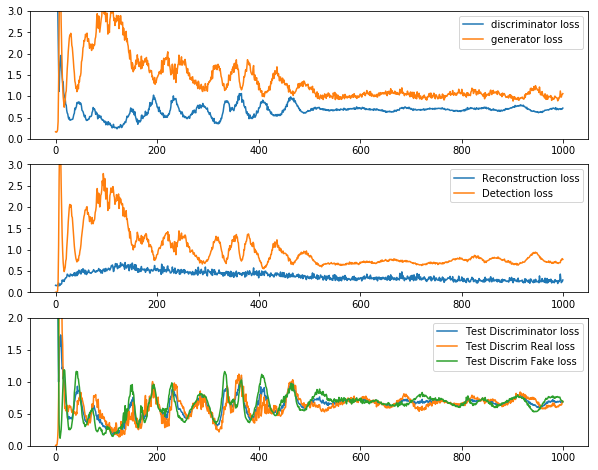

In [16]:
plot_loss(losses,**{'scale_control':[[0,3],[0,3],[0,2]],'loss_weights':loss_weights})

In [17]:
y_hat=Discrim.predict(np.concatenate((x_test,y_test),axis=1))
y_idx = np.argmax(y_hat,axis=1)
print(sum(y_idx==1)/y_idx.shape[0])

0.5256410256410257


In [18]:
from fake_financial import make_fake_data

In [51]:
x_fake=make_fake_data(np.concatenate((x_test,y_test),axis=1),idx_test,ds,num_fakes=780,method='hard',var_scale=0.2)
y_hat=Discrim.predict(x_fake)
y_idx = np.argmax(y_hat,axis=1)
sum(y_idx==1)/y_idx.shape[0]

0.8256410256410256

In [52]:
import pandas as pd
i=64
composed_imgs=Generator.predict([x_test,y_test])
idx=np.hstack(('Revenues',cols[0:199]))
orig=np.hstack((y_test[i],x_test[i,:]))
fakes=np.hstack((composed_imgs[i][-1],composed_imgs[i][0:-1]))
#orig[orig!=0]
#pd.DataFrame({'originals':orig[orig!=0],'fakes':fakes[orig!=0]},index=idx[orig!=0])
df=pd.DataFrame({'originals':orig,'fakes':fakes},index=idx)
df[df.originals!=0]

,fakes,originals
Revenues,0.000738,0.000738
Assets,1.173116,1.363987
pAssets,1.064847,1.000000
pCashAndCashEquivalentsAtCarryingValue,0.230469,0.371226
CashAndCashEquivalentsAtCarryingValue,0.240174,0.254667
LiabilitiesAndStockholdersEquity,1.213046,1.363987
pLiabilitiesAndStockholdersEquity,1.016492,1.000000
NetIncomeLoss,0.132036,0.071316
pNetIncomeLoss,0.163357,0.395014
pStockholdersEquity,0.762361,0.852010


In [49]:
losses=train_for_n_mono(**train_dic)

  0%|          | 0/1000 [00:00<?, ?it/s]

64/64 [==============================] - 0s 44us/step


  0%|          | 1/1000 [00:02<39:06,  2.35s/it]

64/64 [==============================] - 0s 73us/step


  0%|          | 5/1000 [00:02<08:08,  2.04it/s]

64/64 [==============================] - 0s 58us/step


  1%|          | 9/1000 [00:02<04:42,  3.51it/s]

64/64 [==============================] - 0s 59us/step


  1%|▏         | 13/1000 [00:02<03:22,  4.87it/s]

64/64 [==============================] - 0s 48us/step


  2%|▏         | 17/1000 [00:02<02:40,  6.12it/s]

64/64 [==============================] - 0s 56us/step


  2%|▏         | 21/1000 [00:02<02:14,  7.29it/s]

64/64 [==============================] - 0s 37us/step


  2%|▎         | 25/1000 [00:02<01:56,  8.37it/s]

64/64 [==============================] - 0s 76us/step


  3%|▎         | 29/1000 [00:03<01:43,  9.37it/s]

64/64 [==============================] - 0s 69us/step


  3%|▎         | 34/1000 [00:03<01:31, 10.58it/s]

64/64 [==============================] - 0s 106us/step


  4%|▍         | 39/1000 [00:03<01:22, 11.69it/s]

64/64 [==============================] - 0s 33us/step


  4%|▍         | 44/1000 [00:03<01:15, 12.74it/s]

64/64 [==============================] - 0s 44us/step


  5%|▍         | 49/1000 [00:03<01:09, 13.70it/s]

64/64 [==============================] - 0s 34us/step


  5%|▌         | 54/1000 [00:03<01:04, 14.64it/s]

64/64 [==============================] - 0s 54us/step


  6%|▌         | 59/1000 [00:03<01:00, 15.48it/s]

64/64 [==============================] - 0s 44us/step


  6%|▋         | 64/1000 [00:03<00:57, 16.29it/s]

64/64 [==============================] - 0s 63us/step


  7%|▋         | 69/1000 [00:04<00:54, 17.05it/s]

64/64 [==============================] - 0s 56us/step


  7%|▋         | 74/1000 [00:04<00:52, 17.79it/s]

64/64 [==============================] - 0s 63us/step


  8%|▊         | 79/1000 [00:04<00:49, 18.43it/s]

64/64 [==============================] - 0s 36us/step


  8%|▊         | 84/1000 [00:04<00:48, 19.07it/s]

64/64 [==============================] - 0s 33us/step


  9%|▉         | 89/1000 [00:04<00:46, 19.68it/s]

64/64 [==============================] - 0s 62us/step


  9%|▉         | 94/1000 [00:04<00:44, 20.23it/s]

64/64 [==============================] - 0s 46us/step


 10%|▉         | 99/1000 [00:04<00:43, 20.75it/s]

64/64 [==============================] - 0s 37us/step


 10%|█         | 104/1000 [00:04<00:42, 21.28it/s]

64/64 [==============================] - 0s 42us/step


 11%|█         | 109/1000 [00:05<00:40, 21.77it/s]

64/64 [==============================] - 0s 33us/step


 11%|█▏        | 114/1000 [00:05<00:39, 22.26it/s]

64/64 [==============================] - 0s 96us/step


 12%|█▏        | 119/1000 [00:05<00:38, 22.68it/s]

64/64 [==============================] - 0s 40us/step


 12%|█▏        | 124/1000 [00:05<00:37, 23.12it/s]

64/64 [==============================] - 0s 47us/step


 13%|█▎        | 129/1000 [00:05<00:37, 23.53it/s]

64/64 [==============================] - 0s 31us/step


 13%|█▎        | 134/1000 [00:05<00:36, 23.94it/s]

64/64 [==============================] - 0s 36us/step


 14%|█▍        | 139/1000 [00:05<00:35, 24.28it/s]

64/64 [==============================] - 0s 46us/step


 14%|█▍        | 144/1000 [00:05<00:34, 24.62it/s]

64/64 [==============================] - 0s 41us/step


 15%|█▍        | 149/1000 [00:05<00:34, 24.96it/s]

64/64 [==============================] - 0s 36us/step


 15%|█▌        | 154/1000 [00:06<00:33, 25.31it/s]

64/64 [==============================] - 0s 43us/step


 16%|█▌        | 159/1000 [00:06<00:32, 25.61it/s]

64/64 [==============================] - 0s 44us/step


 16%|█▋        | 164/1000 [00:06<00:32, 25.88it/s]

64/64 [==============================] - 0s 38us/step


 17%|█▋        | 169/1000 [00:06<00:31, 26.17it/s]

64/64 [==============================] - 0s 58us/step


 17%|█▋        | 174/1000 [00:06<00:31, 26.45it/s]

64/64 [==============================] - 0s 52us/step


 18%|█▊        | 179/1000 [00:06<00:30, 26.72it/s]

64/64 [==============================] - 0s 50us/step


 18%|█▊        | 184/1000 [00:06<00:30, 27.01it/s]

64/64 [==============================] - 0s 52us/step


 19%|█▉        | 189/1000 [00:06<00:29, 27.25it/s]

64/64 [==============================] - 0s 43us/step


 19%|█▉        | 194/1000 [00:07<00:29, 27.51it/s]

64/64 [==============================] - 0s 41us/step


 20%|█▉        | 199/1000 [00:07<00:28, 27.77it/s]

64/64 [==============================] - 0s 57us/step


 20%|██        | 204/1000 [00:07<00:28, 28.00it/s]

64/64 [==============================] - 0s 44us/step


 21%|██        | 209/1000 [00:07<00:28, 28.22it/s]

64/64 [==============================] - 0s 50us/step


 21%|██▏       | 214/1000 [00:07<00:27, 28.46it/s]

64/64 [==============================] - 0s 104us/step


 22%|██▏       | 219/1000 [00:07<00:27, 28.63it/s]

64/64 [==============================] - 0s 35us/step


 22%|██▏       | 224/1000 [00:07<00:26, 28.84it/s]

64/64 [==============================] - 0s 46us/step


 23%|██▎       | 229/1000 [00:07<00:26, 29.04it/s]

64/64 [==============================] - 0s 45us/step


 23%|██▎       | 234/1000 [00:07<00:26, 29.26it/s]

64/64 [==============================] - 0s 52us/step


 24%|██▍       | 239/1000 [00:08<00:25, 29.46it/s]

64/64 [==============================] - 0s 42us/step


 24%|██▍       | 244/1000 [00:08<00:25, 29.64it/s]

64/64 [==============================] - 0s 34us/step


 25%|██▍       | 249/1000 [00:08<00:25, 29.80it/s]

64/64 [==============================] - 0s 36us/step


 25%|██▌       | 254/1000 [00:08<00:24, 29.99it/s]

64/64 [==============================] - 0s 45us/step


 26%|██▌       | 259/1000 [00:08<00:24, 30.15it/s]

64/64 [==============================] - 0s 46us/step


 26%|██▋       | 264/1000 [00:08<00:24, 30.30it/s]

64/64 [==============================] - 0s 52us/step


 27%|██▋       | 269/1000 [00:08<00:24, 30.43it/s]

64/64 [==============================] - 0s 35us/step


 27%|██▋       | 274/1000 [00:08<00:23, 30.60it/s]

64/64 [==============================] - 0s 46us/step


 28%|██▊       | 279/1000 [00:09<00:23, 30.75it/s]

64/64 [==============================] - 0s 44us/step


 28%|██▊       | 284/1000 [00:09<00:23, 30.90it/s]

64/64 [==============================] - 0s 37us/step


 29%|██▉       | 289/1000 [00:09<00:22, 31.04it/s]

64/64 [==============================] - 0s 36us/step


 29%|██▉       | 294/1000 [00:09<00:22, 31.16it/s]

64/64 [==============================] - 0s 39us/step


 30%|██▉       | 299/1000 [00:09<00:22, 31.29it/s]

64/64 [==============================] - 0s 51us/step


 30%|███       | 304/1000 [00:09<00:22, 31.43it/s]

64/64 [==============================] - 0s 47us/step


 31%|███       | 309/1000 [00:09<00:21, 31.56it/s]

64/64 [==============================] - 0s 33us/step


 31%|███▏      | 314/1000 [00:09<00:21, 31.69it/s]

64/64 [==============================] - 0s 45us/step


 32%|███▏      | 319/1000 [00:10<00:21, 31.82it/s]

64/64 [==============================] - 0s 36us/step


 32%|███▏      | 324/1000 [00:10<00:21, 31.94it/s]

64/64 [==============================] - 0s 57us/step


 33%|███▎      | 329/1000 [00:10<00:20, 32.07it/s]

64/64 [==============================] - 0s 33us/step


 33%|███▎      | 334/1000 [00:10<00:20, 32.20it/s]

64/64 [==============================] - 0s 48us/step


 34%|███▍      | 339/1000 [00:10<00:20, 32.32it/s]

64/64 [==============================] - 0s 37us/step


 34%|███▍      | 344/1000 [00:10<00:20, 32.44it/s]

64/64 [==============================] - 0s 45us/step


 35%|███▍      | 349/1000 [00:10<00:20, 32.54it/s]

64/64 [==============================] - 0s 39us/step


 35%|███▌      | 354/1000 [00:10<00:19, 32.66it/s]

64/64 [==============================] - 0s 49us/step


 36%|███▌      | 359/1000 [00:10<00:19, 32.78it/s]

64/64 [==============================] - 0s 53us/step


 36%|███▋      | 364/1000 [00:11<00:19, 32.89it/s]

64/64 [==============================] - 0s 46us/step


 37%|███▋      | 369/1000 [00:11<00:19, 32.99it/s]

64/64 [==============================] - 0s 72us/step


 37%|███▋      | 374/1000 [00:11<00:18, 33.11it/s]

64/64 [==============================] - 0s 43us/step


 38%|███▊      | 379/1000 [00:11<00:18, 33.19it/s]

64/64 [==============================] - 0s 51us/step


 38%|███▊      | 384/1000 [00:11<00:18, 33.30it/s]

64/64 [==============================] - 0s 56us/step


 39%|███▉      | 389/1000 [00:11<00:18, 33.40it/s]

64/64 [==============================] - 0s 47us/step


 39%|███▉      | 394/1000 [00:11<00:18, 33.50it/s]

64/64 [==============================] - 0s 40us/step


 40%|███▉      | 399/1000 [00:11<00:17, 33.58it/s]

64/64 [==============================] - 0s 56us/step


 40%|████      | 404/1000 [00:11<00:17, 33.68it/s]

64/64 [==============================] - 0s 41us/step


 41%|████      | 409/1000 [00:12<00:17, 33.77it/s]

64/64 [==============================] - 0s 50us/step


 41%|████▏     | 414/1000 [00:12<00:17, 33.86it/s]

64/64 [==============================] - 0s 57us/step


 42%|████▏     | 419/1000 [00:12<00:17, 33.93it/s]

64/64 [==============================] - 0s 46us/step


 42%|████▏     | 424/1000 [00:12<00:16, 34.00it/s]

64/64 [==============================] - 0s 60us/step


 43%|████▎     | 429/1000 [00:12<00:16, 34.08it/s]

64/64 [==============================] - 0s 39us/step


 43%|████▎     | 434/1000 [00:12<00:16, 34.14it/s]

64/64 [==============================] - 0s 47us/step


 44%|████▍     | 439/1000 [00:12<00:16, 34.22it/s]

64/64 [==============================] - 0s 40us/step


 44%|████▍     | 444/1000 [00:12<00:16, 34.29it/s]

64/64 [==============================] - 0s 54us/step


 45%|████▍     | 449/1000 [00:13<00:16, 34.36it/s]

64/64 [==============================] - 0s 33us/step


 45%|████▌     | 454/1000 [00:13<00:15, 34.42it/s]

64/64 [==============================] - 0s 36us/step


 46%|████▌     | 459/1000 [00:13<00:15, 34.50it/s]

64/64 [==============================] - 0s 37us/step


 46%|████▋     | 464/1000 [00:13<00:15, 34.58it/s]

64/64 [==============================] - 0s 55us/step


 47%|████▋     | 469/1000 [00:13<00:15, 34.65it/s]

64/64 [==============================] - 0s 56us/step


 47%|████▋     | 474/1000 [00:13<00:15, 34.72it/s]

64/64 [==============================] - 0s 53us/step


 48%|████▊     | 479/1000 [00:13<00:14, 34.77it/s]

64/64 [==============================] - 0s 36us/step


 48%|████▊     | 484/1000 [00:13<00:14, 34.82it/s]

64/64 [==============================] - 0s 37us/step


 49%|████▉     | 489/1000 [00:14<00:14, 34.84it/s]

64/64 [==============================] - 0s 43us/step


 49%|████▉     | 494/1000 [00:14<00:14, 34.88it/s]

64/64 [==============================] - 0s 42us/step


 50%|████▉     | 498/1000 [00:14<00:14, 34.92it/s]

64/64 [==============================] - 0s 63us/step


 50%|█████     | 502/1000 [00:14<00:14, 34.95it/s]

64/64 [==============================] - 0s 52us/step


 51%|█████     | 506/1000 [00:14<00:14, 34.97it/s]

64/64 [==============================] - ETA:  - 0s 47us/step


 51%|█████     | 511/1000 [00:14<00:13, 35.03it/s]

64/64 [==============================] - 0s 37us/step


 52%|█████▏    | 516/1000 [00:14<00:13, 35.10it/s]

64/64 [==============================] - 0s 45us/step


 52%|█████▏    | 521/1000 [00:14<00:13, 35.16it/s]

64/64 [==============================] - 0s 54us/step


 53%|█████▎    | 526/1000 [00:14<00:13, 35.22it/s]

64/64 [==============================] - 0s 45us/step


 53%|█████▎    | 531/1000 [00:15<00:13, 35.27it/s]

64/64 [==============================] - 0s 39us/step


 54%|█████▎    | 536/1000 [00:15<00:13, 35.33it/s]

64/64 [==============================] - 0s 36us/step


 54%|█████▍    | 541/1000 [00:15<00:12, 35.38it/s]

64/64 [==============================] - 0s 37us/step


 55%|█████▍    | 546/1000 [00:15<00:12, 35.44it/s]

64/64 [==============================] - 0s 37us/step


 55%|█████▌    | 551/1000 [00:15<00:12, 35.50it/s]

64/64 [==============================] - 0s 40us/step


 56%|█████▌    | 556/1000 [00:15<00:12, 35.54it/s]

64/64 [==============================] - 0s 51us/step


 56%|█████▌    | 561/1000 [00:15<00:12, 35.59it/s]

64/64 [==============================] - 0s 55us/step


 57%|█████▋    | 566/1000 [00:15<00:12, 35.63it/s]

64/64 [==============================] - 0s 39us/step


 57%|█████▋    | 571/1000 [00:16<00:12, 35.68it/s]

64/64 [==============================] - 0s 32us/step


 58%|█████▊    | 576/1000 [00:16<00:11, 35.73it/s]

64/64 [==============================] - 0s 46us/step


 58%|█████▊    | 581/1000 [00:16<00:11, 35.79it/s]

64/64 [==============================] - 0s 48us/step


 59%|█████▊    | 586/1000 [00:16<00:11, 35.84it/s]

64/64 [==============================] - 0s 35us/step


 59%|█████▉    | 591/1000 [00:16<00:11, 35.88it/s]

64/64 [==============================] - 0s 66us/step


 60%|█████▉    | 596/1000 [00:16<00:11, 35.93it/s]

64/64 [==============================] - 0s 46us/step


 60%|██████    | 601/1000 [00:16<00:11, 35.97it/s]

64/64 [==============================] - 0s 54us/step


 61%|██████    | 606/1000 [00:16<00:10, 36.02it/s]

64/64 [==============================] - 0s 44us/step


 61%|██████    | 611/1000 [00:16<00:10, 36.06it/s]

64/64 [==============================] - 0s 43us/step


 62%|██████▏   | 616/1000 [00:17<00:10, 36.11it/s]

64/64 [==============================] - 0s 32us/step


 62%|██████▏   | 621/1000 [00:17<00:10, 36.16it/s]

64/64 [==============================] - 0s 38us/step


 63%|██████▎   | 626/1000 [00:17<00:10, 36.19it/s]

64/64 [==============================] - 0s 33us/step


 63%|██████▎   | 631/1000 [00:17<00:10, 36.22it/s]

64/64 [==============================] - 0s 49us/step


 64%|██████▎   | 636/1000 [00:17<00:10, 36.27it/s]

64/64 [==============================] - 0s 37us/step


 64%|██████▍   | 641/1000 [00:17<00:09, 36.30it/s]

64/64 [==============================] - 0s 45us/step


 65%|██████▍   | 646/1000 [00:17<00:09, 36.36it/s]

64/64 [==============================] - 0s 43us/step


 65%|██████▌   | 651/1000 [00:17<00:09, 36.39it/s]

64/64 [==============================] - 0s 35us/step


 66%|██████▌   | 656/1000 [00:18<00:09, 36.42it/s]

64/64 [==============================] - 0s 48us/step


 66%|██████▌   | 661/1000 [00:18<00:09, 36.45it/s]

64/64 [==============================] - 0s 41us/step


 67%|██████▋   | 666/1000 [00:18<00:09, 36.49it/s]

64/64 [==============================] - 0s 32us/step


 67%|██████▋   | 671/1000 [00:18<00:09, 36.53it/s]

64/64 [==============================] - 0s 37us/step


 68%|██████▊   | 676/1000 [00:18<00:08, 36.57it/s]

64/64 [==============================] - 0s 43us/step


 68%|██████▊   | 681/1000 [00:18<00:08, 36.60it/s]

64/64 [==============================] - 0s 57us/step


 69%|██████▊   | 686/1000 [00:18<00:08, 36.64it/s]

64/64 [==============================] - 0s 44us/step


 69%|██████▉   | 691/1000 [00:18<00:08, 36.67it/s]

64/64 [==============================] - 0s 39us/step


 70%|██████▉   | 696/1000 [00:18<00:08, 36.71it/s]

64/64 [==============================] - 0s 45us/step


 70%|███████   | 701/1000 [00:19<00:08, 36.74it/s]

64/64 [==============================] - 0s 35us/step


 71%|███████   | 706/1000 [00:19<00:07, 36.77it/s]

64/64 [==============================] - 0s 35us/step


 71%|███████   | 711/1000 [00:19<00:07, 36.79it/s]

64/64 [==============================] - 0s 47us/step


 72%|███████▏  | 716/1000 [00:19<00:07, 36.83it/s]

64/64 [==============================] - 0s 38us/step


 72%|███████▏  | 721/1000 [00:19<00:07, 36.86it/s]

64/64 [==============================] - 0s 37us/step


 73%|███████▎  | 726/1000 [00:19<00:07, 36.90it/s]

64/64 [==============================] - 0s 35us/step


 73%|███████▎  | 731/1000 [00:19<00:07, 36.93it/s]

64/64 [==============================] - 0s 41us/step


 74%|███████▎  | 736/1000 [00:19<00:07, 36.96it/s]

64/64 [==============================] - 0s 53us/step


 74%|███████▍  | 741/1000 [00:20<00:07, 36.98it/s]

64/64 [==============================] - 0s 61us/step


 75%|███████▍  | 746/1000 [00:20<00:06, 37.03it/s]

64/64 [==============================] - 0s 54us/step


 75%|███████▌  | 751/1000 [00:20<00:06, 37.05it/s]

64/64 [==============================] - 0s 48us/step


 76%|███████▌  | 756/1000 [00:20<00:06, 37.08it/s]

64/64 [==============================] - 0s 47us/step


 76%|███████▌  | 761/1000 [00:20<00:06, 37.11it/s]

64/64 [==============================] - 0s 54us/step


 77%|███████▋  | 766/1000 [00:20<00:06, 37.14it/s]

64/64 [==============================] - 0s 38us/step


 77%|███████▋  | 771/1000 [00:20<00:06, 37.15it/s]

64/64 [==============================] - 0s 58us/step


 78%|███████▊  | 776/1000 [00:20<00:06, 37.15it/s]

64/64 [==============================] - 0s 83us/step


 78%|███████▊  | 781/1000 [00:21<00:05, 37.17it/s]

64/64 [==============================] - 0s 37us/step


 78%|███████▊  | 785/1000 [00:21<00:05, 37.17it/s]

64/64 [==============================] - 0s 40us/step


 79%|███████▉  | 789/1000 [00:21<00:05, 37.17it/s]

64/64 [==============================] - 0s 76us/step


 79%|███████▉  | 793/1000 [00:21<00:05, 37.17it/s]

64/64 [==============================] - 0s 66us/step


 80%|███████▉  | 797/1000 [00:21<00:05, 37.18it/s]

64/64 [==============================] - 0s 47us/step


 80%|████████  | 801/1000 [00:21<00:05, 37.16it/s]

64/64 [==============================] - 0s 79us/step


 80%|████████  | 805/1000 [00:21<00:05, 37.16it/s]

64/64 [==============================] - 0s 56us/step


 81%|████████  | 809/1000 [00:21<00:05, 37.16it/s]

64/64 [==============================] - 0s 40us/step


 81%|████████▏ | 813/1000 [00:21<00:05, 37.16it/s]

64/64 [==============================] - 0s 54us/step


 82%|████████▏ | 818/1000 [00:21<00:04, 37.18it/s]

64/64 [==============================] - 0s 36us/step


 82%|████████▏ | 823/1000 [00:22<00:04, 37.20it/s]

64/64 [==============================] - 0s 49us/step


 83%|████████▎ | 827/1000 [00:22<00:04, 37.20it/s]

64/64 [==============================] - 0s 54us/step


 83%|████████▎ | 832/1000 [00:22<00:04, 37.23it/s]

64/64 [==============================] - 0s 58us/step


 84%|████████▎ | 837/1000 [00:22<00:04, 37.25it/s]

64/64 [==============================] - 0s 48us/step


 84%|████████▍ | 842/1000 [00:22<00:04, 37.28it/s]

64/64 [==============================] - 0s 61us/step


 85%|████████▍ | 847/1000 [00:22<00:04, 37.29it/s]

64/64 [==============================] - 0s 34us/step


 85%|████████▌ | 852/1000 [00:22<00:03, 37.31it/s]

64/64 [==============================] - 0s 36us/step


 86%|████████▌ | 857/1000 [00:22<00:03, 37.33it/s]

64/64 [==============================] - 0s 49us/step


 86%|████████▌ | 862/1000 [00:23<00:03, 37.35it/s]

64/64 [==============================] - 0s 40us/step


 87%|████████▋ | 867/1000 [00:23<00:03, 37.37it/s]

64/64 [==============================] - 0s 52us/step


 87%|████████▋ | 872/1000 [00:23<00:03, 37.39it/s]

64/64 [==============================] - 0s 45us/step


 88%|████████▊ | 877/1000 [00:23<00:03, 37.41it/s]

64/64 [==============================] - 0s 71us/step


 88%|████████▊ | 882/1000 [00:23<00:03, 37.44it/s]

64/64 [==============================] - 0s 39us/step


 89%|████████▊ | 887/1000 [00:23<00:03, 37.45it/s]

64/64 [==============================] - 0s 46us/step


 89%|████████▉ | 892/1000 [00:23<00:02, 37.47it/s]

64/64 [==============================] - 0s 47us/step


 90%|████████▉ | 897/1000 [00:23<00:02, 37.49it/s]

64/64 [==============================] - 0s 51us/step


 90%|█████████ | 902/1000 [00:24<00:02, 37.50it/s]

64/64 [==============================] - 0s 64us/step


 91%|█████████ | 907/1000 [00:24<00:02, 37.51it/s]

64/64 [==============================] - 0s 44us/step


 91%|█████████ | 912/1000 [00:24<00:02, 37.52it/s]

64/64 [==============================] - 0s 35us/step


 92%|█████████▏| 917/1000 [00:24<00:02, 37.52it/s]

64/64 [==============================] - 0s 64us/step


 92%|█████████▏| 922/1000 [00:24<00:02, 37.54it/s]

64/64 [==============================] - 0s 46us/step


 93%|█████████▎| 927/1000 [00:24<00:01, 37.55it/s]

64/64 [==============================] - 0s 36us/step


 93%|█████████▎| 931/1000 [00:24<00:01, 37.56it/s]

64/64 [==============================] - 0s 42us/step


 94%|█████████▎| 936/1000 [00:24<00:01, 37.57it/s]

64/64 [==============================] - 0s 62us/step


 94%|█████████▍| 941/1000 [00:25<00:01, 37.60it/s]

64/64 [==============================] - 0s 49us/step


 95%|█████████▍| 946/1000 [00:25<00:01, 37.62it/s]

64/64 [==============================] - 0s 53us/step


 95%|█████████▌| 951/1000 [00:25<00:01, 37.63it/s]

64/64 [==============================] - 0s 56us/step


 96%|█████████▌| 956/1000 [00:25<00:01, 37.65it/s]

64/64 [==============================] - 0s 52us/step


 96%|█████████▌| 961/1000 [00:25<00:01, 37.67it/s]

64/64 [==============================] - 0s 36us/step


 97%|█████████▋| 966/1000 [00:25<00:00, 37.69it/s]

64/64 [==============================] - 0s 39us/step


 97%|█████████▋| 971/1000 [00:25<00:00, 37.71it/s]

64/64 [==============================] - 0s 47us/step


 98%|█████████▊| 976/1000 [00:25<00:00, 37.71it/s]

64/64 [==============================] - 0s 71us/step


 98%|█████████▊| 981/1000 [00:26<00:00, 37.69it/s]

64/64 [==============================] - 0s 35us/step


 98%|█████████▊| 985/1000 [00:26<00:00, 37.68it/s]

64/64 [==============================] - 0s 63us/step


 99%|█████████▉| 989/1000 [00:26<00:00, 37.67it/s]

64/64 [==============================] - 0s 44us/step


 99%|█████████▉| 993/1000 [00:26<00:00, 37.66it/s]

64/64 [==============================] - 0s 66us/step


100%|█████████▉| 997/1000 [00:26<00:00, 37.65it/s]

64/64 [==============================] - 0s 41us/step


100%|██████████| 1000/1000 [00:26<00:00, 37.67it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

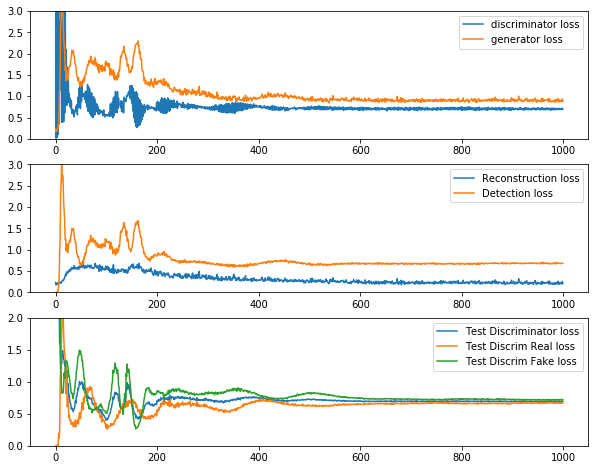

In [50]:
loss_weights=[5,1]
plot_loss(losses,**{'scale_control':[[0,3],[0,3],[0,2]],'loss_weights':loss_weights})